# FIT5148 - Big data management and processing assignment

# Assignment Task C Data Visualisation#

#### Team Members:

1. 27033074 - Matthew Yeow Yit Hang

2. 26546736 - Borris Trendy Wiria



#### Import required libraries

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

import sys
import time
import json
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pprint import pprint
from kafka import KafkaConsumer
import matplotlib.pyplot as plt

#### 3a. Streaming data visualization

In [ ]:
def annotate_max(x, y, ax = None):
    '''
    Marks the maximum in the matplot graph figure.
    '''
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max| Time: {}\nAir Temp: {} °C'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.7),)
    
def annotate_min(x, y, ax = None):
    '''
    Marks the minimum in the matplot graph figure.
    '''
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min| Time: {}\nAir Temp: {} °C'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.7),)
        
def init_plots():
    '''
    Initialisation of matplot graph figure.
    
    return: blank graph with initialised graph title, scaling of x and y axis and their labels.
    '''
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Arrival Time vs Air Temperature') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,40)  #we tested in R that the max temp is at 32°C
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=600000, # stop iteration if no message after 10 mins
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[bootstrap_servers],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def consume_messages(consumer, fig, ax):
    '''
    Consumer which takes messages from Kafka and updates the graph figure based on the new messages' values.
    '''
    try:
        x, y = [], []
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(',')
            if data[-1] == climate1:
                x.append(data[-2]) # Arrival Time of the climate data
                y.append(int(data[2])) # Air temperature of the climate data
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time (hrs)')
                ax.set_ylabel('Air Temperature (°C)')
                ax.set_ylim(0,40)  #we tested in R that the max temp is at 32°C
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                if len(x) > 6:   # to maintain 7 data points on the graph
                    x.pop(0)
                    y.pop(0)   
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))

if __name__ == '__main__':
    '''
    Variable initialisation
    '''
    topic = "climate_hotspot"
    climate1 = "climate_1"
    bootstrap_servers = '127.0.0.1:9092'

    %matplotlib notebook  
    # this line is needed for the inline display of graphs in Jupyter Notebook
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

#### 3b. Static Data Visualization####

i. The database used for this task is independent of Task C 2. because the format is different. But, the implementation of the database is the same.

#### Import required libraries

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

import sys
import time
import json
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pprint import pprint
from kafka import KafkaConsumer
import matplotlib.pyplot as plt

There are no hotspots.


<IPython.core.display.Javascript object>


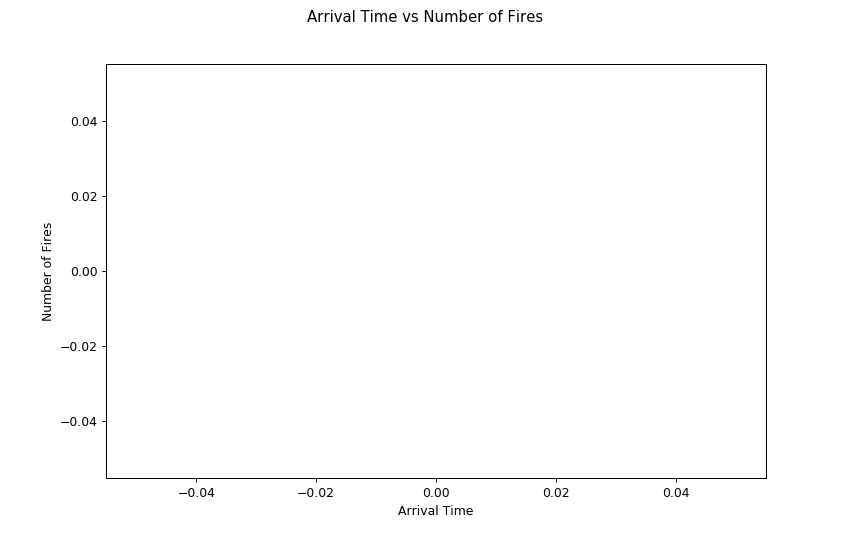

In [5]:
client = MongoClient()
db = client.fit5148_assignment_db
streaming = db.streaming

query = streaming.aggregate([
    { "$unwind" :'$hotspot'},
    { "$group": {
        "_id":"$hotspot.arrival_time", 
        "count": {"$sum":1} }
    },
    { "$sort": {"count": -1}},  # sort based on time
    {"$limit":10}   # limit to top 10 results
])

x, y = [],[]
xy_array = []
for i in query:
    xy_array.append([i["_id"], i["count"]])

if xy_array != []:
    xy_array = sorted(xy_array,key=lambda x: x[0])  # sort based on time first
    xy_array = sorted(xy_array,key=lambda x: x[1], reverse=True)  # sort based on count
    x, y = zip(*xy_array)
else:
    print("There are no hotspots.")

def bar_plot():
    try:
        global x,y
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Arrival Time vs Number of Fires') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Number of Fires')
        #ax.set_ylim(0,20) 
        #ax.set_yticks([0,1,2,60,80,100])
        ax.bar(x,y)
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
        
%matplotlib notebook  
# this line is needed for the inline display of graphs in Jupyter Notebook
bar = bar_plot()

Test for correctness with plotting bar chart figure of number of hotspots in a climate document in Task B

<IPython.core.display.Javascript object>


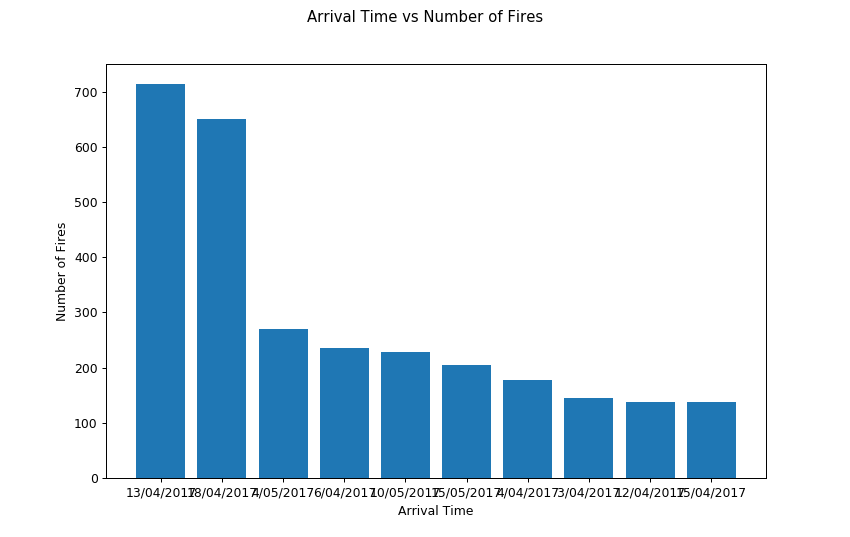

In [6]:
'''
This is only for testing
'''
client = MongoClient()
db = client.fit5148_assignment_db
streaming = db.climate

query = streaming.aggregate([
    { "$unwind" :'$hotspot'},
    { "$group": {
        "_id":"$hotspot.date", 
        "count": {"$sum":1} }
    },
    { "$sort": {"count":-1,}}, # sort based on descending count
    {"$limit":10}
])

x, y = [],[]
for i in query:
    x.append(i["_id"])  # _id is the hotspot.date
    y.append(i["count"])
    
def bar_plot():
    try:
        global x,y
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Arrival Time vs Number of Fires') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Number of Fires')
        #ax.set_ylim(0,20) 
        #ax.set_yticks([0,1,2,60,80,100])
        ax.bar(x,y)
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
        
%matplotlib notebook  
# this line is needed for the inline display of graphs in Jupyter Notebook
bar = bar_plot()

ii. Fire locations plotting

In [7]:
import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.4713, 144.7852, 8) # latitude and longitude of melbourne city

from pymongo import MongoClient

client = MongoClient()
db = client.fit5148_assignment_db
streaming = db.streaming

# Preparing the data for plotting
latsList, longList, titleList = [], [], []

# unwind to get all hotspot data
query = streaming.aggregate([
    { "$unwind" :'$hotspot'}
])

for row in query:
    if row["hotspot"] != [] :
        # Adding the latitude and longitude & necessary data
        latsList.append(float(row["hotspot"]['latitude']))
        longList.append(float(row["hotspot"]['longitude']))
        titleList.append("surface temp: "+str(row["hotspot"]["surface_temperature_celcius"])+
                        ", confidence: "+str(row["hotspot"]["confidence"])+
                         ", air temp: "+str(row["air_temperature_celcius"])+
                         ", relative humidity: "+str(row["relative_humidity"])
                        )

In [8]:
titleList

[]

In [9]:
# The step below is required by the gmap scatter function to prepare data in correct format
#unoccupied_lats, unoccupied_lons = zip(*unoccupiedList) 
for i in range(len(latsList)):
    gmap.marker(latsList[i], longList[i], title=titleList[i])
    
import webbrowser
# Drawing the map
gmap.draw("fireMap.html")
webbrowser.open_new("fireMap.html")

True